# IAPR: Lab 3 ‒ Classification
### Group ID: xx

#### Author 1 (sciper): Yerkin Yesbay (343883)
#### Author 2 (sciper): Pranav Krishna (359822)

In [153]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
import tarfile
import os

data_base_path = os.path.join('data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [178]:
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.covariance import LedoitWolf
import seaborn as sns
from sklearn.metrics import classification_report

# Part 1

In [156]:
import torch 

# Label mapping
label_to_classname = {0 : "TUMOR", 1 : "STROMA"}

# Train features and labels
train_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_features.pth"))
train_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_labels.pth"))

# Test features and labels
test_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_features.pth"))
test_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_labels.pth"))

test_features.shape

torch.Size([186, 768])

In [157]:
train_data = np.hstack((train_features,train_labels.reshape(-1,1)))
test_data = np.hstack((train_features,train_labels.reshape(-1,1)))

print(train_features.shape)
train_labels.reshape(-1,1).shape

torch.Size([878, 768])


(878, 1)

## 1.1 Binary classifier with Mahalanobis distance

In [161]:
from numpy import linalg

def mahalanobis_dist(x,inv,mu):
    output = np.dot(inv,x-mu)
    output = np.dot(x-mu, output)
    return np.sqrt(output)

class mahalanobis_classifier():
    def __init__(self):
        self.covariances = []
        self.inverses = []
        self.means = []
        self.n_classes = 2
        self.labels = None
        
    def fit(self,X_train,y_train):
        self.n_classes = len(np.unique(y_train))
        self.labels = np.unique(y_train)
        for i in range(self.n_classes):
            data = X_train[y_train==self.labels[i]]
            #print(data)
            cov = LedoitWolf().fit(data).covariance_
            mu = np.mean(data,axis=0)
            inv = linalg.inv(cov)
            self.covariances.append(cov)
            self.means.append(mu)
            self.inverses.append(inv)
        
    def predict(self, X_test):
        output = []
        for x in X_test:
            distances = [mahalanobis_dist(x,self.inverses[i],self.means[i]) for i in range(self.n_classes)]
            output.append(self.labels[np.argmin(distances)])
        return np.array(output)
    
    def get_min_distances(self, X_test):
        output = []
        for x in X_test:
            distances = [mahalanobis_dist(x,self.inverses[i],self.means[i]) for i in range(self.n_classes)]
            output.append(min(distances))
        return np.array(output)

### Tasks 1 and 2

In [179]:
X_train = train_features.numpy()
y_train = train_labels
X_test = test_features.numpy()
y_test = test_labels

clf = mahalanobis_classifier()
clf.fit(X_train,y_train)
y_hat = clf.predict(X_test)

print("Accuracy",np.mean(y_hat==y_test))

Accuracy 0.978494623655914


## 1.2 Out-of-Distribution detection with Mahalanobis distance

In [163]:
label_to_classname_w_ood = {0 : "TUMOR", 1 : "STROMA", -1 : "OoD"}

# Test features and labels with OoD tissues
test_features_w_ood = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test2_features.pth"))
test_labels_w_ood = torch.load(os.path.join(data_base_path, data_folder,"part1/k16_test2_labels.pth"))

test_features_w_ood.shape

torch.Size([744, 768])

### Task 1

If we know that a datapoint belongs to one of the clusters (Tumor or Stroma class) then one of the Mahalanobis distances is likely to be small, so the minimum Mahalanobis distance is unlikely to be large for non-OOD points.

### Task 2 

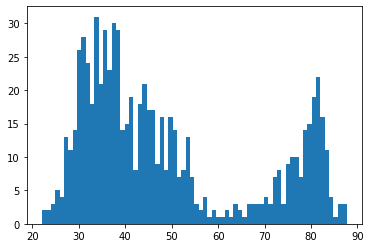

In [164]:
X_test_new = test_features_w_ood.numpy()
y_test_new = test_labels_w_ood

distances = clf.get_min_distances(X_test_new)
plt.hist(distances,bins=70)
plt.show()

### Task 3 

Below are the histogram and kde plot of minimum Mahalanobis distances for Tumor, Stroma and OOD samples. We can see that minimum Mahalanobis distance does not separate the classes from OOD very well, although non-OOD samples tend to be closer.

<AxesSubplot:ylabel='Density'>

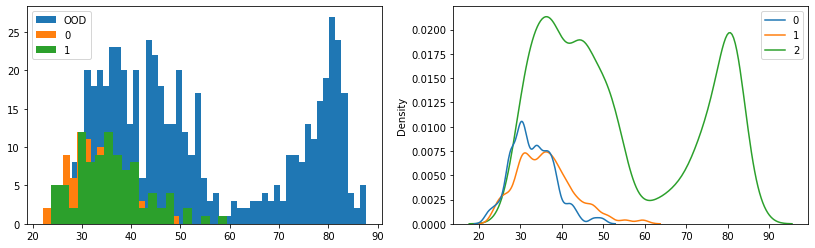

In [165]:
index_0 = (y_test_new==0)
distances_0 = distances[y_test_new==0]
distances_1 = distances[y_test_new==1]
distances_ood = distances[y_test_new==-1]
fig, ax = plt.subplots(ncols=2,figsize=(14,4))
ax[0].hist(distances_ood,bins=50,label='OOD')
ax[0].hist(distances_0,bins=20,label='0')
ax[0].hist(distances_1,bins=20,label='1')
ax[0].legend()
sns.kdeplot(data=[distances_0,distances_1,distances_ood],bw_adjust=0.5,ax=ax[1])

### Tasks 4 and 5

Too many non-OOD samples get filtered out. The classwise scores are not satisfactory

In [181]:
thresh_ood_5 = np.sort(distances_ood)[int(len(distances_ood)*0.05)]
print("95% threshold (0.05 quantile) for OOD samples:",thresh_ood_5)

y_hat_new = np.zeros_like(y_test_new)
for i in range(len(X_test_new)):
    if distances[i]>thresh_ood_5:
        y_hat_new[i] = -1
    else:
        y_hat_new[i] = clf.predict([X_test_new[i]])[0]
        
print('Class 0 filtered out:',sum(distances_0>thresh_ood_5)/len(distances_0))
print('Class 1 filtered out:',sum(distances_1>thresh_ood_5)/len(distances_1))
print(classification_report(y_test_new,y_hat_new))

95% threshold (0.05 quantile) for OOD samples: 30.65177
Class 0 filtered out: 0.6129032258064516
Class 1 filtered out: 0.7634408602150538
              precision    recall  f1-score   support

          -1       0.81      0.95      0.87       558
           0       0.57      0.39      0.46        93
           1       0.96      0.24      0.38        93

    accuracy                           0.79       744
   macro avg       0.78      0.52      0.57       744
weighted avg       0.80      0.79      0.76       744



## 1.3 Out-of-distribution detection with k-NN classifier

### Task 1

In [182]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier

class KNNClassifier(KNeighborsClassifier):
    def ood_metric(self,X,k_neighbors=None,p=2):
        if k_neighbors==None:
            k_neighbors=self.n_neighbors            
        neigh_distances = self.kneighbors(X,k_neighbors,return_distance=True)[0]
        neigh_distances = np.array(neigh_distances)
        output = []
        for d in neigh_distances:
            if p==0:
                out = np.max(d)
            elif p=='infty':
                out = np.min(d)
            else:
                out = np.sum(d**p)**(1/p)
            output.append(out)
        return np.array(output)
    def predict_ood(self,X,metrics,threshold,ood_label=-1):
        output = self.predict(X)
        for i in range(len(X)):
            if metrics[i]>threshold:
                output=ood_label
        return output
            
knn = KNNClassifier(n_neighbors=5,weights='distance') # brute knn
knn.fit(X_train,y_train)
y_hat_brute = knn.predict(X_test)
print("Accuracy",np.mean(y_hat_brute==y_test))

Accuracy 0.9946236559139785


### Task 2
We started with a custom OOD metric, which is based on distances $d_1,\dots,d_k$ to the $k$ closest neighbors within the training dataset. It measures $l_p$ (preudo-) norm of and vector of $(d_1,\dots,d_k)$ with $0 \leq p \leq \infty$.

Looking at the smoothed histograms, we can see that for some values of $(p,k)$ this metric separates the OOD and non-OOD samples a bit better.

Text(0.5, 1.0, 'p = 10, k_neighbors=10')

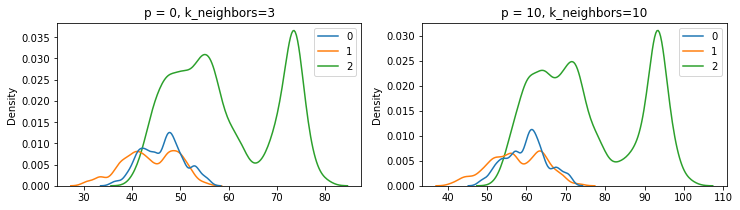

In [174]:
fig, axs = plt.subplots(ncols=2,figsize = (12,3))
p = 0
k_neighbors = 3
metrics_0 = knn.ood_metric(X_test_new[y_test_new==0],k_neighbors=k_neighbors,p=p)
metrics_1 = knn.ood_metric(X_test_new[y_test_new==1],k_neighbors=k_neighbors,p=p)
metrics_ood = knn.ood_metric(X_test_new[y_test_new==-1],k_neighbors=k_neighbors,p=p)
sns.kdeplot(data=[metrics_0,metrics_1,metrics_ood],bw_adjust=0.5,ax=axs[0])
axs[0].set_title(f"p = {p}, k_neighbors={k_neighbors}")

p = 10
k_neighbors = 10
metrics_0 = knn.ood_metric(X_test_new[y_test_new==0],k_neighbors=k_neighbors,p=p)
metrics_1 = knn.ood_metric(X_test_new[y_test_new==1],k_neighbors=k_neighbors,p=p)
metrics_ood = knn.ood_metric(X_test_new[y_test_new==-1],k_neighbors=k_neighbors,p=p)
sns.kdeplot(data=[metrics_0,metrics_1,metrics_ood],bw_adjust=0.5,ax=axs[1])
axs[1].set_title(f"p = {p}, k_neighbors={k_neighbors}")

We also tried to outlier detection using LocalOutlierFactor method available in sklearn. One important input to it is the minimum number of points that are required to define a cluster, call it minpts.

This method calculates a 'k-distance' $\alpha$ such that at least k objects are in the closed ball of radius $\alpha$ and at least k-1 are in the open ball of radius $\alpha$. Next this distance is combined with the distances within the 'k-nearest' neighbours of the point by taking the maximum of this and the maximum distance between points in its vicinity to get the reachability distance. After this, we take the average of the reciprocals of the rachability distance for the 'k-nearest' neighbours of this point to get the local reachability density. This is used to define the local outlier factor as in the name by taking the average proportion of local reachability distance normalised to the lrd of the given point for the min-pts nearest neighbours.

Next, a threshold is chosen to give predictions regarding OOD-characteristic of the points.

0.05 quantile of OOD samples: 30.65177
class 0 filtered out: 0.5591397849462365
class 1 filtered out: 0.5698924731182796
              precision    recall  f1-score   support

          -1       0.87      0.95      0.91       558
           0       0.68      0.56      0.62        93
           1       0.91      0.56      0.69        93

    accuracy                           0.85       744
   macro avg       0.82      0.69      0.74       744
weighted avg       0.85      0.85      0.84       744



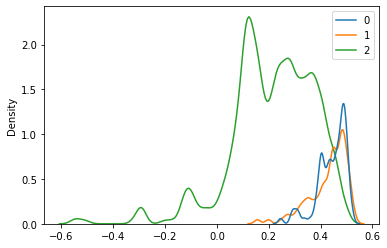

In [183]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=3,novelty=True)
lof.fit(X_train,y_train)

goodness_score = lof.decision_function(X_test_new)
goodness_0 = lof.decision_function(X_test_new[y_test_new==0])
goodness_1 = lof.decision_function(X_test_new[y_test_new==1])
goodness_ood = lof.decision_function(X_test_new[y_test_new==-1])

sns.kdeplot(data=[goodness_0,goodness_1,goodness_ood],bw_adjust=0.4)

thresh_ood_95 = np.sort(goodness_ood)[int(len(goodness_ood)*0.95)]
print("0.05 quantile of OOD samples:",thresh_ood_5)

y_hat_new = np.zeros_like(y_test_new)
for i in range(len(X_test_new)):
    if goodness_score[i]<thresh_ood_95:
        y_hat_new[i] = -1
    else:
        y_hat_new[i] = clf.predict([X_test_new[i]])[0]
        
print('class 0 filtered out:',sum(goodness_0>thresh_ood_95)/len(goodness_0))
print('class 1 filtered out:',sum(goodness_1>thresh_ood_95)/len(goodness_1))
print(classification_report(y_test_new,y_hat_new))

### Task 3

The k-NN based OOD detection was better. It yields better accuracy after filtering and when we filter out 95% of OOD samples, the percentage of filtered out in-distribution samples is smaller for k-NN than that for Mahalnobis distance.

Possible reasons for that: Mahalanobis distance is a reliable factor under the assumption of gaussianity of the features withing classes. It only cares about the cluster mean and the covariance structure, while k-NN is a more local algorithm so it is able to incorporate more information from the nearby points of clusters.

# Part 2

In [184]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
import skimage.io
from torch import nn
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [185]:
data_base_path = os.path.join('data')
data_folder = 'lab-03-data'

tar = tarfile.open(os.path.join(data_base_path, data_folder + '.tar.gz'), 'r:gz')
tar.extractall()
tar.close()

In [186]:
features_path = 'lab-03-data/part2/sipakmed_clean_embeddings.pth'

## 2.1 Dataset

In [187]:
class Sipakmed(Dataset):
    phase_dict = {
            'train': {'start': 0.0, 'stop': 0.5},
            'val': {'start': 0.5, 'stop': 0.75},
            'test': {'start': 0.75, 'stop': 1.0}
    }
    label_dict = {
        'im_Superficial-Intermediate': 0,
        'im_Parabasal': 1, 
        'im_Metaplastic': 2,
        'im_Koilocytotic': 3,
        'im_Dyskeratotic': 4
    }
    
    def __init__(self, features_path, phase):

        super(Sipakmed, self).__init__()
        # Store class attributes
        self.phase = phase
        
        # Collect the dataimport torch
        import torch.nn.functional as F
        import numpy as np
        self.raw_data = torch.load(features_path)
        self.features, self.labels, self.paths = self.collect_data()
        
    def collect_data(self):
        # Iterate over the dirs/classes
        features, labels, paths = [], [], []
        for dir_name, dir_dict in self.raw_data.items():
            # Get the paths and embeddings
            dir_paths, dir_embeddings = list(zip(*[(k, v) for k, v in dir_dict.items()]))
            
            # Split
            n = len(dir_paths)
            np.random.seed(42)
            permutations = np.random.permutation(n)
            dir_paths = np.array(dir_paths)[permutations]
            dir_embeddings = torch.stack(dir_embeddings)[permutations]
            n_start = int(n * self.phase_dict[self.phase]['start'])
            n_stop = int(n * self.phase_dict[self.phase]['stop'])
            dir_embeddings = dir_embeddings[n_start: n_stop]
            dir_paths = dir_paths[n_start: n_stop]
    
            # Store
            features.append(dir_embeddings)
            paths.append(dir_paths)
            dir_labels = torch.tensor([self.label_dict[p.split('/')[-2]] for p in dir_paths])
            labels.append(dir_labels)
            
        # Merge
        features = torch.cat(features)
        labels = torch.cat(labels)
        paths = np.concatenate(paths)
        return features, labels, paths
            
        
    def __len__(self,):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.features)
    
    def __getitem__(self, index):
        """
        Returns the embedding, label, and image path of queried index.
        """
        embedding = self.features[index]
        label = self.labels[index]
        path = self.paths[index]
        return embedding, label, path

In [194]:
# Instantiate the datasets
train_dataset = Sipakmed(features_path=features_path, phase='train')
val_dataset = Sipakmed(features_path=features_path, phase='val')
test_dataset = Sipakmed(features_path=features_path, phase='test')

In [195]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

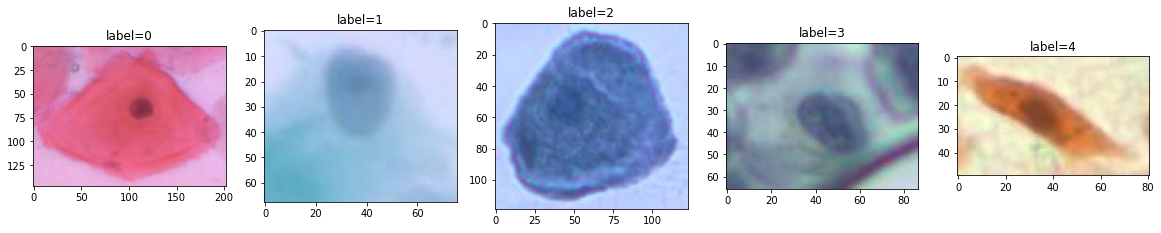

In [196]:
#visualize some training samples
np.random.seed(42)
fig,axs = plt.subplots(ncols=5,figsize=(20,4))

for label in range(5):
    n = (train_dataset.labels==label).sum()
    rand_ind = np.random.randint(n)
    label_paths = train_dataset.paths[train_dataset.labels==label]
    img_path = 'lab-03-data/part2/'+label_paths[rand_ind]
    img = skimage.io.imread(img_path)
    axs[label].set_title(f'label={label}')
    axs[label].imshow(img)
sample_0 = train_dataset[train_dataset.labels==0][0]

## 2.2 Training

In [11]:
import torch.nn as nn
import torch.optim as optim

class MyModel(nn.Module):
    def __init__(self,input_size,conv_sizes,pool_sizes,drop_p=0.25):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=conv_sizes[0])
        self.pool1 = nn.MaxPool1d(pool_sizes[0])
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=conv_sizes[1])
        self.pool2 = nn.MaxPool1d(pool_sizes[1])
        #self.conv3 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=conv_sizes[2])
        #self.pool3 = nn.MaxPool1d(pool_sizes[2])
        self.fc_input_size = self.get_fc_input_size(torch.randn(1,input_size))
        self.fc1 = nn.Linear(self.fc_input_size, 5)
        #self.fc2 = nn.Linear(20, 5)
        self.dropout = nn.Dropout(p=drop_p)
        self.sigmoid = nn.Sigmoid()
    
    def get_fc_input_size(self,x):
        output = self.conv1(x)
        output = self.pool1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.pool2(output)
        #output = self.conv3(output)
        #output = self.pool3(output)
        return output.shape[-1]
    
    def forward(self, x):
        output = self.conv1(x)
        output = self.pool1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.pool2(output)
        output = self.relu(output)
        #output = self.conv3(output)
        #output = self.pool3(output)
        #output = self.relu(output)
        
        output = self.fc1(output)
        #output = self.relu(output)
        #output = self.fc2(output)
        output = self.dropout(output)
        #output = self.sigmoid(output)
        return output

In [197]:
activation = nn.Sigmoid()

def accuracy(outputs, labels):
    """
    Computes the accuracy of predictions based on the model outputs (NxK: N samples, K classes) 
    and the labels (N: N samples).
    """
    preds = torch.argmax(activation(outputs), dim=1).flatten()
    return (preds == labels).sum()/labels.shape[0]

In [62]:
def train(model, optimizer, scheduler, criterion, loader, l1_lambda=0, l2_lambda=0, scheduled=True):
    # Set the model in train mode
    model.train()
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    losses = []
    for x_batch, y_batch, path in loader:
        # Reset the gradients
        model.zero_grad()
        # Feed the embeddings to the model
        outp = model(x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[1])).reshape(
            x_batch.shape[0], 5)
        # Compute cross entropy loss
        loss = criterion(outp, y_batch)
        l1_reg, l2_reg = torch.tensor(0.), torch.tensor(0.)
        for param in model.fc1.parameters():
            l2_reg += torch.norm(param, p=2)
            l1_reg += torch.norm(param, p=1)
        if l1_lambda > 0:
            loss += l1_lambda * l1_reg
        if l2_lambda > 0:
            loss += l2_lambda * l2_reg
        # Backpropagate
        loss.backward()
        # Update the parameters
        optimizer.step()
        # Store the outputs, labels and loss
        full_outputs.append(outp)
        full_labels.append(y_batch)
        losses.append(loss.detach())
    if scheduled:
        scheduler.step()
    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    
    # Compute the accuracy
    acc = accuracy(full_outputs,full_labels)
    return acc, full_outputs, full_labels, losses

In [61]:
@torch.no_grad()
def validate(model, criterion, loader, l1_lambda=0, l2_lambda=0):
    # Set the model in evaluation mode
    model.eval()
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    full_paths = []
    losses = []
    # Get the embeddings, labels and paths
    for x_batch, y_batch, path in loader:
        # Feed the embeddings to the model
        outp = model(x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[1])).reshape(
                    x_batch.shape[0], 5)
        # Compute cross entropy loss
        loss = criterion(outp, y_batch).detach()
        l1_reg, l2_reg = torch.tensor(0.), torch.tensor(0.)
        for param in model.fc1.parameters():
            l2_reg += torch.norm(param, p=2).detach()
            l1_reg += torch.norm(param, p=1).detach()
        if l1_lambda > 0:
            loss += l1_lambda * l1_reg
        if l2_lambda > 0:
            loss += l2_lambda * l2_reg
        # Store the outputs, labels and loss
        full_outputs.append(outp)
        full_labels.append(y_batch)
        losses.append(loss)
        full_paths.append(path)
        
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    full_paths = np.concatenate(full_paths)
    
    # Compute the accuracy
    acc = accuracy(full_outputs,full_labels)
    return acc, full_outputs, full_labels, losses, full_paths

In [64]:
# Main loop
#model_savepath = '../data'
import copy

epochs = 500
best_acc = 0

model_new = MyModel(input_size=2048,conv_sizes=[21,15],pool_sizes=[3,2],drop_p=0.2)

lr = 0.003
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_new.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.6)

l1_lambda = 0.0001
#l2_lambda = 0.0001

accuracies = {"train": [], "val": []}

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    # Train
    train_res = train(model_new, optimizer, scheduler, criterion, train_loader, l1_lambda, l2_lambda=0,scheduled=True)
    scheduler.step()
    train_acc = train_res[0]
    print(f"Stage: train. Accuracy: {train_acc}")
    
    # Evaluate
    val_res = validate(model_new, criterion, val_loader, l1_lambda, l2_lambda=0)
    val_acc = val_res[0]
    print(f"Stage: validation. Accuracy: {val_acc}")
    
    accuracies['train'].append(train_acc)
    accuracies['val'].append(val_acc)
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_weights = copy.deepcopy(model_new.state_dict())

Epoch: 1
Stage: train. Accuracy: 0.48961424827575684
Stage: validation. Accuracy: 0.7994071245193481
Epoch: 2
Stage: train. Accuracy: 0.741345226764679
Stage: validation. Accuracy: 0.8389328122138977
Epoch: 3
Stage: train. Accuracy: 0.8001978397369385
Stage: validation. Accuracy: 0.8646245002746582
Epoch: 4
Stage: train. Accuracy: 0.8264095187187195
Stage: validation. Accuracy: 0.8922924995422363
Epoch: 5
Stage: train. Accuracy: 0.8491592407226562
Stage: validation. Accuracy: 0.8952569365501404
Epoch: 6
Stage: train. Accuracy: 0.859050452709198
Stage: validation. Accuracy: 0.9011857509613037
Epoch: 7
Stage: train. Accuracy: 0.8684470653533936
Stage: validation. Accuracy: 0.8893280625343323
Epoch: 8
Stage: train. Accuracy: 0.857566773891449
Stage: validation. Accuracy: 0.9110671877861023
Epoch: 9
Stage: train. Accuracy: 0.8778437376022339
Stage: validation. Accuracy: 0.9110671877861023
Epoch: 10
Stage: train. Accuracy: 0.8738872408866882
Stage: validation. Accuracy: 0.9160078763961792
E

Stage: train. Accuracy: 0.9268051385879517
Stage: validation. Accuracy: 0.9150197505950928
Epoch: 84
Stage: train. Accuracy: 0.9159248471260071
Stage: validation. Accuracy: 0.9150197505950928
Epoch: 85
Stage: train. Accuracy: 0.9119683504104614
Stage: validation. Accuracy: 0.9150197505950928
Epoch: 86
Stage: train. Accuracy: 0.9094955325126648
Stage: validation. Accuracy: 0.9150197505950928
Epoch: 87
Stage: train. Accuracy: 0.9188922047615051
Stage: validation. Accuracy: 0.9150197505950928
Epoch: 88
Stage: train. Accuracy: 0.9070227742195129
Stage: validation. Accuracy: 0.9150197505950928
Epoch: 89
Stage: train. Accuracy: 0.9094955325126648
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 90
Stage: train. Accuracy: 0.9124628901481628
Stage: validation. Accuracy: 0.9150197505950928
Epoch: 91
Stage: train. Accuracy: 0.9179030656814575
Stage: validation. Accuracy: 0.9150197505950928
Epoch: 92
Stage: train. Accuracy: 0.9188922047615051
Stage: validation. Accuracy: 0.9150197505950928


Stage: validation. Accuracy: 0.9160078763961792
Epoch: 165
Stage: train. Accuracy: 0.91147381067276
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 166
Stage: train. Accuracy: 0.9124628901481628
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 167
Stage: train. Accuracy: 0.9080118536949158
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 168
Stage: train. Accuracy: 0.9109792113304138
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 169
Stage: train. Accuracy: 0.9169139266014099
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 170
Stage: train. Accuracy: 0.9134520292282104
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 171
Stage: train. Accuracy: 0.908506453037262
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 172
Stage: train. Accuracy: 0.9030662775039673
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 173
Stage: train. Accuracy: 0.9193867444992065
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 174
Stage: train. Accuracy: 0.

Stage: train. Accuracy: 0.9139465689659119
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 246
Stage: train. Accuracy: 0.9193867444992065
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 247
Stage: train. Accuracy: 0.9080118536949158
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 248
Stage: train. Accuracy: 0.924332320690155
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 249
Stage: train. Accuracy: 0.9208704233169556
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 250
Stage: train. Accuracy: 0.9208704233169556
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 251
Stage: train. Accuracy: 0.9174085259437561
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 252
Stage: train. Accuracy: 0.9134520292282104
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 253
Stage: train. Accuracy: 0.9109792113304138
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 254
Stage: train. Accuracy: 0.9193867444992065
Stage: validation. Accuracy: 0.916007876

Epoch: 327
Stage: train. Accuracy: 0.9070227742195129
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 328
Stage: train. Accuracy: 0.919881284236908
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 329
Stage: train. Accuracy: 0.9159248471260071
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 330
Stage: train. Accuracy: 0.919881284236908
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 331
Stage: train. Accuracy: 0.9149357080459595
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 332
Stage: train. Accuracy: 0.9179030656814575
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 333
Stage: train. Accuracy: 0.9188922047615051
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 334
Stage: train. Accuracy: 0.9139465689659119
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 335
Stage: train. Accuracy: 0.91147381067276
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 336
Stage: train. Accuracy: 0.912957489490509
Stage: validation. Accuracy: 0.91

Stage: validation. Accuracy: 0.9160078763961792
Epoch: 409
Stage: train. Accuracy: 0.9169139266014099
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 410
Stage: train. Accuracy: 0.9233432412147522
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 411
Stage: train. Accuracy: 0.908506453037262
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 412
Stage: train. Accuracy: 0.9035608172416687
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 413
Stage: train. Accuracy: 0.9134520292282104
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 414
Stage: train. Accuracy: 0.9203758835792542
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 415
Stage: train. Accuracy: 0.9253214597702026
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 416
Stage: train. Accuracy: 0.9154302477836609
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 417
Stage: train. Accuracy: 0.9154302477836609
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 418
Stage: train. Accuracy: 

Stage: train. Accuracy: 0.912957489490509
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 490
Stage: train. Accuracy: 0.91147381067276
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 491
Stage: train. Accuracy: 0.9060336351394653
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 492
Stage: train. Accuracy: 0.9233432412147522
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 493
Stage: train. Accuracy: 0.9169139266014099
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 494
Stage: train. Accuracy: 0.9149357080459595
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 495
Stage: train. Accuracy: 0.9154302477836609
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 496
Stage: train. Accuracy: 0.9183976054191589
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 497
Stage: train. Accuracy: 0.9263105988502502
Stage: validation. Accuracy: 0.9160078763961792
Epoch: 498
Stage: train. Accuracy: 0.9149357080459595
Stage: validation. Accuracy: 0.91600787639

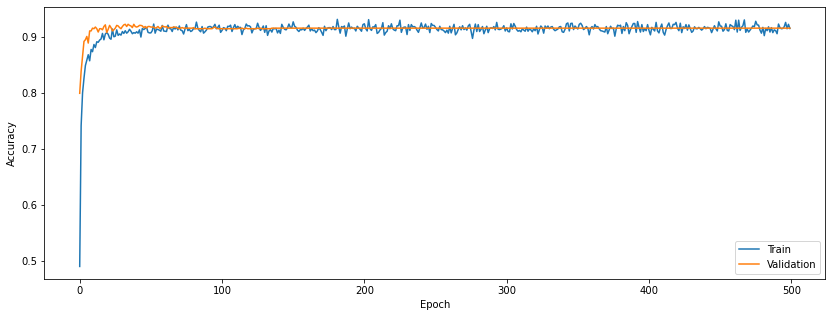

Best validation accuracy 0.9229249


In [198]:
plt.figure(figsize=(14,5))
plt.plot(accuracies['train'],label='Train')
plt.plot(accuracies['val'],label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print("Best validation accuracy",best_acc.numpy())

## 2.3 Evaluation

In [199]:
# Re-load the best model
model_new.load_state_dict(best_model_weights)

# Evaluate
model_new.eval()
test_res = validate(model_new, criterion, test_loader, l1_lambda=0, l2_lambda=0)
test_acc = test_res[0]
print("Test accuracy of the best model",test_acc.numpy())

Test accuracy of the best model 0.92413795


In [200]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
n_test = len(test_dataset)
test_out = model_new(test_dataset.features.reshape(n_test,1, 2048)).reshape(n_test,5).detach()
y_pred = torch.argmax(activation(test_out), dim=1).flatten().numpy()
y_test = test_dataset.labels.numpy()
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[206   1   0   1   0]
 [  0 190   1   1   5]
 [  2   2 185   7   3]
 [  2   1  14 175  15]
 [  0   3   4  15 182]]


We can see that images of label 3 are often misclassified as 2, and labels 3 and 4 are often confused.

In [201]:
# Find the misclassified samples
misclassified_mask = (pred_labels!=test_dataset.labels.numpy())
misclassified_paths = test_dataset.paths[misclassified_mask]

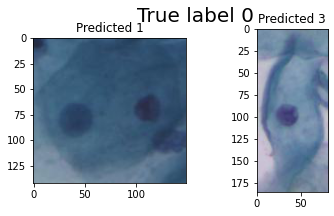

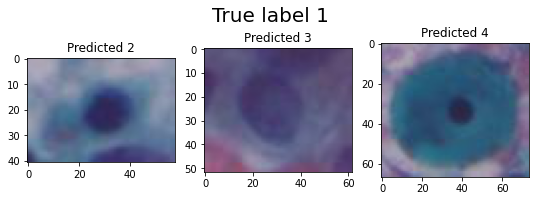

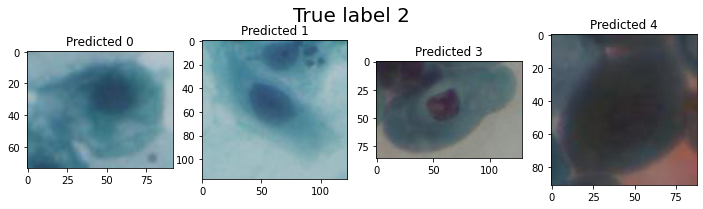

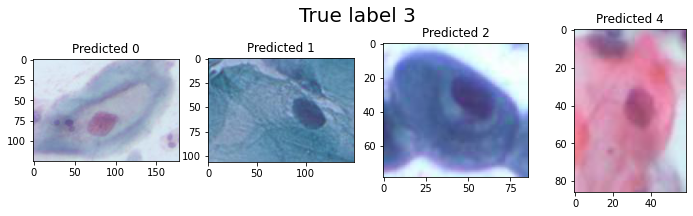

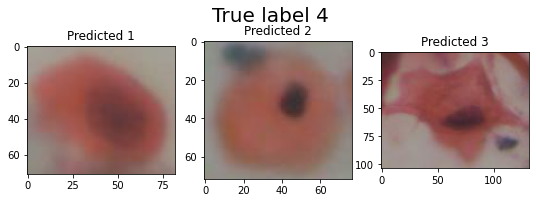

In [204]:
# Plot the misclassified samples
for true_label in range(5):
    cols = sum(conf_mat[true_label]>0)-1
    fig, axs = plt.subplots(ncols=cols,figsize=(3*cols,3))
    num = 0
    for pred_label in range(5):
        if pred_label!=true_label:
            mask = (y_test==true_label)*(y_pred==pred_label)
            if sum(mask)>0:
                misclassified_path = 'lab-03-data/part2/'+test_dataset.paths[mask][0]
                misclassified_img = skimage.io.imread(misclassified_path)
                axs[num].imshow(misclassified_img)
                axs[num].set_title(f"Predicted {pred_label}")
                num+=1
    fig.suptitle(f'True label {true_label}', fontsize=20)